In [16]:
# Author: Andi Sama
# Organization: Sinergi Wahana Gemilang
#   a Value Added Distributor in Jakarta, Indonesia
# Created: June 18, 2018
# Last modified:
#   - June 19, 2018
#     * Add a few more information during training by modifying code in network_asm.py
#       (% on classification rate & elapsed time per epoch + total elapsed time for all epochs)
#     * Add a few more information during training by modifying code in mnist_loader_asm.py
#       (loaded data sizes)
#   - June 21, 2018
#     * Apply cross-entropy on cost function (previously: use quadratic cost) to improve accuracy
#     * Apply Mini-batch gradient descent (previously: just Stochastic Gradient Descent)
#     * Add monitor_elapsed_time flag in network2_asm.py
#     * Draw plot for training cost, evaluation cost against # of epoch
#     * Use Gaussian distributions with mean 0 and standard deviation 1 over the square root
#       of the number of weights connecting to the same neuron for network initialization
#       (previously: Gaussian distribution without square root)
#   - June 23, 2018
#     * Use regularization - lambda 
#     * Visualization of mnist dataset
#   - June 24, 2018
#       Add predict() function use existing function load() network after save()
#       => vanilla version done
#   - June 24, 2018
#     * use mnist testing dataset to predict (now still using training data)
#   - June 25-26, 2018
#     * migrate to IBM Watson Studio (on cloud)
#       - upload all files to IBM object storage
#       - get all files to working directory by using IBM boto3 api
#       - convert code from python 2.7 to 3.5 (print function, cPickle handler, xrange)
#   - June 28, 2018
#     retrain with lambda = 0 (no regularization, for article - for SWG Insights Q4 2018)
#   - July 9-12, 2018
#     change framework to keras (change MNIST input to numpy.ndarray)
#   - July 14-15, 2018
#     use Conv2D with Keras (change environment to 2 vCPU and 8GB RAM <prev 1vCPU, 4GB>)
# Topic: Beginning Deep Learning (computer vision)
# Purpose: Recognizing handwritten digits 0-9 in 3 steps
#   - 1. Prepare datasets (MNIST, modified nist database)
#   - 2. Train, Validate on datasets to generate deep learning model (architecture, weights)
#   - 3. Predict new data based on generated model with testing data 
# Type of Neural Network: Supervised Learning with shallow neural network
#   Dataset: mnist
#     - original training dataset (60,000): handwritten digits from 250 persons (2 groups)
#       further then divided to be 50,000 for training dataset and 10,000 for validation dataset
#     - testing dataset (10,000): handwritten digits from another set of 250 persons (2 groups)
# Hardware & Software platforms:
#   - environment: cygwin on Windows, on Thinkpad T450 (i7 4 vCPUs without GPUs, 16 GB RAM)
#   - programming language: python (v2.7)
#   - deep learning framework: none
#   - libraries: sys, pandas, numpy, math, matplotlib, botocore, ibm_boto3
# Reference:
#   - Michael A. Nielsen, "Neural Network & Deep Learning",
#     Determination Press, 2015 http://neuralnetworksanddeeplearning.com 
#     Original code from the book is at https://github.com/mnielsen/neural-networks-and-deep-learning
#   - various references from stackoverflow, github, and related library documentations etc

In [17]:
# GET ALL REQUIRED FILES to working directory by using IBM boto3 api
# Just need to do this once, comment afterward
#
import sys
import types
import pandas as pd # dataframe manipulations
from botocore.client import Config # to access IBM Object Storage
import ibm_boto3 # to access IBM Object Storage

# LOAD required libraries
import matplotlib.pyplot as plt # graphic related things
import numpy as np # matrix manipulations
import math # math functions

In [18]:
# The code was removed by DSX for sharing.

In [19]:
# Above cell is hidden for publishing... get your own key from IBM Watson Studio on IBM cloud to fill the following
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# replace "your IBM API Key" with your generated key
# s3 = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='your IBM API Key',
#     ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

In [20]:
# replace the following "mybucket" with your generated bucket
mybucket='doctorofcomputerscience-donotdelete-pr-e1zj6xtk1pjpth'
# 1. get mnist dataset
with open('mnist.pkl.gz', 'wb') as data:
    s3.download_fileobj(mybucket, 'mnist.pkl.gz', data)
# 2. get pyton library for loading mnist dataset
with open('mnist_loader_asm_py3.py', 'wb') as data:
    s3.download_fileobj(mybucket, 'mnist_loader_asm_py3.py', data)
# 3. get pyton library for training & prediction
with open('network2_asm_b_py3.py', 'wb') as data:
    s3.download_fileobj(mybucket, 'network2_asm_b_py3.py', data)
# file for testing to predict(), get pre-trained network (without retraining)
# 2 hidden layers at 30 neurons each, lr=0.15, batch size=32, no regularization
# result: train cost: 0.0609736142951, eval cost: 0.229741976137, train acc: 99.416 %, eval acc: 96.89 %
# June 28 2018: Total time for 50 Epochs are: 681.4261889457703 seconds on IBM Cloud (1vCPU 4 GB RAM)
with open('2018624223944_asm_Trained_NN', 'wb') as data:
    s3.download_fileobj(mybucket, '2018628165028_asm_Trained_NN', data)

In [21]:
# LOAD our specific libraries
import mnist_loader_asm_py3 # helper program for loading mnist data set
# import network2_asm_b_py3 # helper program, neural network layers

In [22]:
#plot individual curve: training training/evaluation accuracy, training/evaluation cost
def plot_curve(xlabel, epoch, ylabel, loss):
    # epoch: total epoch, loss: list of lost values for all epochs
    epochs = []
    for i in range(epoch):
        epochs.append(i)
    plt.plot(epochs,loss)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
#compare training & evaluation accuracy / cost
def plot_curve_comparison(epoch, title, xlabel, data1, ylabel, data2):
    epochs = []
    for i in range(epoch):
        epochs.append(i)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.plot(epochs, data1, label=xlabel)
    ax.plot(epochs, data2, label=ylabel)
    plt.title(title)
    ax.legend()
    plt.show()

# draw a 28x28 pixels digit from 784x1 input array
def draw_digit(input):
    row = 1
    column = 1
    for i in range(column):
        #get corresponding target label (y) "digit" from its vectorized format
        #then, plot the image data 
        image = input.reshape(28, 28)   
        plt.subplot(row, column, 1)  # subplot with size  
        plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
        plt.axis('on')  # show axis value
        plt.tight_layout()  # automatic padding between subplots
        plt.show()

In [23]:
# ========================
# 1. LOAD Dataset (MNIST)
# ========================
# 1a. load mnist data using mnist_loader library
#   output is structured in such a way to fit and be ready for learning
#   each data is in 784x1 dimension, reshape to 28x28 pixels for viewing
#   each label is in 8x1 dimension,
#     extract array content with "1" in it to get the actual label ["0".."9"]
#
zip_training_data, zip_validation_data, zip_test_data = mnist_loader_asm_py3.load_data_wrapper()

>> Training dataset (x, y)], length: 2 arrays.
  - 1st array (data, x) 28x28 pixels; total data: 50000 , length per data: 784
  - 2nd array (target label, y) [0..9]; total data: 50000
    sample dataset: 5


In [24]:
training_data = list(zip_training_data)
validation_data = list(zip_validation_data)
test_data = list(zip_test_data)

A few samples for the 28x28 pixels mnist digit dataset with its corresponding label


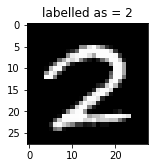

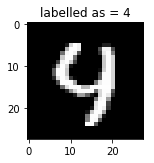

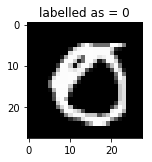

In [25]:
# 1b. just show a few sample digits with its corresponding labels
#
print("A few samples for the 28x28 pixels mnist digit dataset with its corresponding label")
row = 1
column = 3
np.random.shuffle(training_data) # just resuffle so we are showing different data when refreshed
for i in range(column):
    #get corresponding target label (y) "digit" from its vectorized format
    data = training_data[i][1]
    digit=0
    j=0
    for x in data:
        if int(x):
            digit=j
            break
        else:
            j=j+1
    #then, plot the image data 
    image = training_data[i][0].reshape(28, 28)   
    plt.subplot(row, column, i+1)  # subplot with size  
    plt.imshow(image, cmap='gray')  # cmap='gray' is for black and white picture.
    plt.title('labelled as = {0}'.format(digit))
    plt.axis('on')  # do not show axis value
    plt.tight_layout()  # automatic padding between subplots
    filename = "mnist_plot"+str(i)+".png"
    plt.savefig(filename)
    plt.show()

In [26]:
# x_train
print(training_data[0][0].shape)
# y_train
print(training_data[0][1].shape)

(784, 1)
(10, 1)


In [27]:
training_data_ndarray = np.array(training_data)
# xtmp_train, ytmp_train (temporary before adjusted for keras)
xtmp_train, ytmp_train = training_data_ndarray[:, :-1], training_data_ndarray[:, -1]
# print(xtmp_train.shape, xtmp_train[0][0].shape)
# print(ytmp_train.shape, ytmp_train[0].shape)

In [28]:
# preparing x_train "x" data to be suitable for input to keras framework (for training)
# with dimension 50,000 x 784
# x_train will be ready for Keras.Dense layer
i=0
row=len(xtmp_train)
column=len(xtmp_train[0][0])
# print(row, column)
x_train = np.zeros((row, column))
# print(x_train.shape)
while(i<(len(xtmp_train)-1)):
    x_train[i] = np.reshape(xtmp_train[i][0], (1,784))
    i=i+1

x_train = x_train.reshape(row, 28, 28, 1) # Preparing x_train to be ready for Keras.Conv2D layer
    
# preparing y_train "y" data to be suitable for input to keras framework (for training)
# with dimension 50,000 x 10
i=0
row=len(ytmp_train)
column=len(ytmp_train[0])
# print(row, column)
y_train = np.zeros((row, column))
# print(y_train.shape)
while(i<(len(ytmp_train)-1)):
    y_train[i] = np.reshape(ytmp_train[i], (1,10))
    i=i+1

In [29]:
print(x_train.shape)

(50000, 28, 28, 1)


In [30]:
# July 14 2018: use keras framework with default: tensorflow
# create VGG-like network, see https://keras.io/layers/convolutional/
import keras 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential()
#input layer with 784 neurons arranged in 28x28, with 1st hidden layer as Conv2D
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) 

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5)) 

# output layer, 10 neurons (digits 0..9)
model.add(Dense(units=10, activation='softmax'))
          
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True))

In [31]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [32]:
# our x_train and y_train in numpy.ndarray format that are now ready as expected by keras framework
print(x_train.shape, y_train.shape)

(50000, 28, 28, 1) (50000, 10)


In [33]:
# # ==================================================
# # 2. TRAIN the Neural Network (SUPERVISED LEARNING)
# # ==================================================
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
50000/50000 [==============================] - 319s 6ms/step - loss: 0.2964
Epoch 2/10
50000/50000 [==============================] - 323s 6ms/step - loss: 0.0924
Epoch 3/10
50000/50000 [==============================] - 321s 6ms/step - loss: 0.0642
Epoch 4/10
50000/50000 [==============================] - 325s 6ms/step - loss: 0.0566
Epoch 5/10
50000/50000 [==============================] - 326s 7ms/step - loss: 0.0490
Epoch 6/10
50000/50000 [==============================] - 326s 7ms/step - loss: 0.0425
Epoch 7/10
50000/50000 [==============================] - 322s 6ms/step - loss: 0.0382
Epoch 8/10
50000/50000 [==============================] - 322s 6ms/step - loss: 0.0364
Epoch 9/10
50000/50000 [==============================] - 319s 6ms/step - loss: 0.0308
Epoch 10/10
50000/50000 [==============================] - 320s 6ms/step - loss: 0.0311


In [34]:
# 2b. save the last trained network sizes, weights, biases, cost
#
# generate current time to be embedded in filename
import time
dt = time.localtime(time.time())
i=0
prefix = ""
while i<6:
    #print str(dt[i])
    prefix = prefix + str(dt[i])
    i=i+1
# embed the current time in file name
filename = prefix + "_asm_Trained_NN_Keras_Conv2D"
print("saving:", filename, "...")
model.save_weights(filename)
print("done.")

saving: 2018714195532_asm_Trained_NN_Keras_Conv2D ...
done.


In [35]:
# # 2c. load trained network for prediction
# # e.g. filename = 2018714195532_asm_Trained_NN_Keras_Conv2D
# filename = 2018714195532_asm_Trained_NN_Keras_Conv2D
# print("loading:", filename, "...")
# model.load_weights(filename)
# print("done.")

In [36]:
# preparing test_data suitable for input to keras framework (for prediction)
# with dimension 10,000 x 784
# x_test will be ready for Keras.Dense layer
test_data_ndarray = np.array(test_data)
xtmp_data, ytmp_data = test_data_ndarray[:, :-1], test_data_ndarray[:, -1]
row=len(test_data_ndarray)
column=len(test_data_ndarray[0][0])
# print(row, column)
x_test_data = np.zeros((row, column))
i=0
while(i<row-1):
    x_test_data[i] = xtmp_data[i][0].reshape(1,784)
    i=i+1
print(x_test_data.shape)

# Preparing x_test to be ready for Keras.Conv2D layer
x_test_data = x_test_data.reshape(row, 28, 28, 1)
print(x_test_data.shape)

(10000, 784)
(10000, 28, 28, 1)


test_data index = 9365


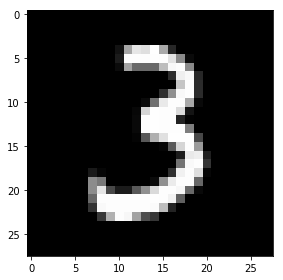

running digit prediction...
1/1 [==============================] - 0s 23ms/step
labeled as:  3
recognized as:  3


In [37]:
# # =========== 
# # 3. PREDICT
# # =========== 
import random
random_value = random.randint(0, row-1)
# print(x_test_data[random_value].shape)
y_test_data = test_data_ndarray[random_value][1]
print("test_data index =", random_value)
image = x_test_data[random_value]
draw_digit(image)
print("running digit prediction...")
result = model.predict(image.reshape(1,28,28,1), batch_size=None, verbose=1, steps=None)
print("labeled as: ", y_test_data)
print("recognized as: ", np.argmax(result))

In [38]:
# upload the trained data to IBM Object Storage
with open(filename, 'rb') as data:
    s3.upload_fileobj(data, mybucket, filename)

In [ ]:
!ls -al